<div style="text-align: center;">
    <span style="font-size:30px; font-weight: bold;">Autoencoder for MNIST Reconstruction</span>
</div>

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 0.1429 - psnr: 9.2404 - ssim: 0.0632 - val_loss: 0.0707 - val_psnr: 11.6143 - val_ssim: 0.0967
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.0673 - psnr: 11.8805 - ssim: 0.1148 - val_loss: 0.0696 - val_psnr: 11.6846 - val_ssim: 0.1001
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.0673 - psnr: 11.8772 - ssim: 0.1150 - val_loss: 0.0707 - val_psnr: 11.5984 - val_ssim: 0.1103
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.0672 - psnr: 11.8822 - ssim: 0.1146 - val_loss: 0.0712 - val_psnr: 11.5903 - val_ssim: 0.1474
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - loss: 0.0672 - psnr: 11.8872 - ssim: 0.1154 - val_loss: 0.0818 - val_psnr: 10.9562 - val_ssim: 0.1481
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.0673 - psnr: 11.8791 - ssim: 0.1150 - val_loss: 0.0793 - val_psnr: 11.1501 - val_ssim: 0.1661
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step

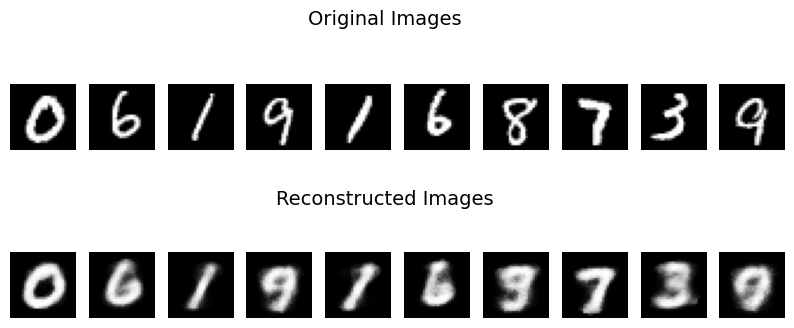

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# MNIST Data Import
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocessing - Normalize and Reshape Data
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

x_train = x_train.reshape(-1, 28, 28, 1) # Converting 2d images, 1 represents single channel for Gray Scale Images
x_test = x_test.reshape(-1, 28, 28, 1)

# Perform Data Augmentation to improve results
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest', # After transformations, gaps are filled with the nearest pixel
    brightness_range = [0.8, 1.2]

)
datagen.fit(x_train)

# metric for PSNR
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# metric for SSIM
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def Autoencoder(input_dim, latent_dim):
    # Encoder Part
    encoder_input = layers.Input(shape = input_dim)
    x = layers.Flatten()(encoder_input) # Convert 2D input into a 1D vector. Dimensions should be (batch size, 28*28) = (batxh_size, 784) 
    x = layers.Dense(512, activation='relu')(x)  # (batche_size, 512)
    x = layers.Dense(256, activation = 'relu')(x)  # (batch_size, 256)
    x = layers.Dense(128, activation = 'relu')(x)  # (batch_size, 128)

    latent = layers.Dense(latent_dim, activation='relu')(x) # (batch_size, latent_dim)

    # Decoder Part
    decoder_input = layers.Input(shape=(latent_dim,)) # (batch_size, latent_dim)
    x = layers.Dense(128, activation = 'relu')(decoder_input) # (128, batch_size)
    x = layers.Dense(256, activation = 'relu')(x) # (256, batch_size) 
    x = layers.Dense(512, activation='relu')(x)  # (512, batch_size)
    x = layers.Dense(np.prod(input_shape), activation = 'sigmoid')(x) 

    decoder_output = layers.Reshape(input_shape)(x) # Reshape into original dimentions -> (batch_size, 28, 28, 1)

    # Create the Encoder and Decoder Models
    encoder = models.Model(encoder_input, latent) #input =(batch, 28, 28, 1) and output = (batch_size, latent_dim)
    decoder = models.Model(decoder_input, decoder_output) # the opposite of encoder
    autoencoder = models.Model(encoder_input, decoder(encoder(encoder_input)))

    return encoder, decoder, autoencoder

# Create autoencoder
input_shape = x_train.shape[1:] # this should be (28, 28, 1) == (height, width, number of channels)
latent_dim = 256 # Choose Dimensions for Latent
encoder, decoder, autoencoder = Autoencoder(input_shape, latent_dim)

# Compile autoencoder
# autoencoder.compile(optimizer = 'adam', loss = 'mse')
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=[psnr, ssim])

# Traun autoencoder
epoch_num = 50
batch_num = 128
autoencoder.fit(datagen.flow(x_train, x_train, batch_size=batch_num), epochs=epoch_num, validation_data=(x_test, x_test))

# Test the model (Reconstruction Part)
def visualize_reconstruction(x_test, autoencoder, n = 5):
    # Get Random Sample from TestSet
    idx = np.random.choice(x_test.shape[0], n, replace = False)
    original_img = x_test[idx]
    # Autoencoder Predict and Get Reconstructed Image
    reconstructed_img = autoencoder.predict(original_img)
    
    # Plot Original vs Reconstructed Image
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_img[i].reshape(28, 28), cmap='gray') # Reshape Back to (28, 28)
        plt.axis('off')
        
        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_img[i].reshape(28, 28), cmap='gray') 
        plt.axis('off')
    
    plt.figtext(0.5, 0.95, 'Original Images', ha='center', va='center', fontsize=14)
    plt.figtext(0.5, 0.5, 'Reconstructed Images', ha='center', va='center', fontsize=14)    
    plt.show()

# Call Image Visualization function that plots Original vs Reconstructed Image for 10 samples 
visualize_reconstruction(x_test, autoencoder, n = 10)


<div style="text-align: center;">
    <span style="font-size:30px; font-weight: bold;">Autoencoder with Convolutional Layers</span>
</div>

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 102ms/step - loss: 0.9992 - mse: 0.1187 - val_loss: 0.8713 - val_mse: 0.0731
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - loss: 0.8914 - mse: 0.0816 - val_loss: 0.7781 - val_mse: 0.0765
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 116ms/step - loss: 0.8897 - mse: 0.0814 - val_loss: 0.7450 - val_mse: 0.0769
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 125ms/step - loss: 0.8890 - mse: 0.0811 - val_loss: 0.6900 - val_mse: 0.0697
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 132ms/step - loss: 0.8887 - mse: 0.0812 - val_loss: 0.7121 - val_mse: 0.0738
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 128ms/step - loss: 0.8889 - mse: 0.0810 - val_loss: 0.6511 - val_mse: 0.0620
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 128ms/step - loss: 0.8866 - mse: 0.0809 - val_loss: 0.6576 - val_mse: 0.0620
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 127ms/step - loss: 0.8871 - mse: 0.0810 - val_loss: 0.5722 - val_mse: 0.0537
Epoch 9/50
469/469 ━━━━━━━━━━━━━

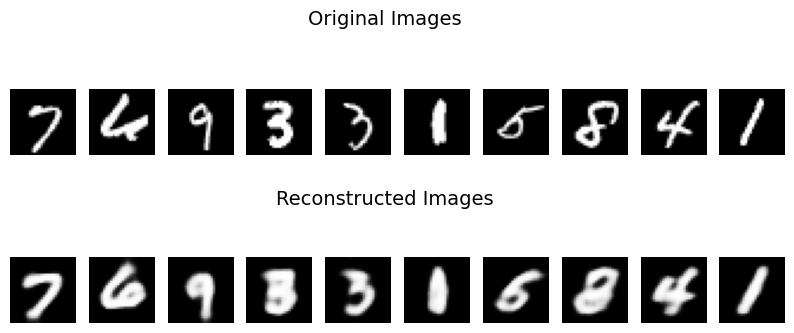

In [72]:
def custom_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim = tf.reduce_mean(1 - tf.image.ssim(y_true, y_pred, max_val=1.0))
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    loss = mse + ssim + 0.1 * l1_loss  # Combining losses, with L1 weighted
    return loss

# Autoencoder but this time with Convolutional Layers
def AutoencoderWithConvLayers(input_shape, latent_dim):
    # Encoder Part
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder Part
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation='relu')(decoder_input)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Create Encoder and Decoder models
    encoder = models.Model(encoder_input, latent)
    decoder = models.Model(decoder_input, decoder_output)
    autoencoder = models.Model(encoder_input, decoder(encoder(encoder_input)))

    return encoder, decoder, autoencoder

# Create autoencoder
input_shape = x_train.shape[1:] # this should be (28, 28, 1) == (height, width, number of channels)
latent_dim = 512 # Choose Dimensions for Latent
encoder, decoder, autoencoder = AutoencoderWithConvLayers(input_shape, latent_dim)

# Compile Autoencoder
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=custom_loss, metrics=['mse'])

# Train Autoencoder
epochs = 50
batch_size = 128
autoencoder.fit(datagen.flow(x_train, x_train, batch_size=batch_size),
                epochs=epochs,
                validation_data=(x_test, x_test))

# Visualization Function
def visualize_reconstruction(x_test, autoencoder, n=5):
    idx = np.random.choice(x_test.shape[0], n, replace=False)
    original_img = x_test[idx]
    reconstructed_img = autoencoder.predict(original_img)

    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_img[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_img[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

    plt.figtext(0.5, 0.95, 'Original Images', ha='center', fontsize=14)
    plt.figtext(0.5, 0.5, 'Reconstructed Images', ha='center', fontsize=14)
    plt.show()

# Visualize Reconstructed Images
visualize_reconstruction(x_test, autoencoder, n=10)


<div style="text-align: center;">
    <span style="font-size:30px; font-weight: bold;">Autoencoder for Digit Recognition</span>
</div>

In [73]:
from tensorflow.keras.utils import to_categorical
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)  
y_test = to_categorical(y_test, 10)

# Define CNN for Digit Recognition
def cnn_digit_rec(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Create the model
input_shape = x_train.shape[1:]  # (28, 28, 1)
cnn_digit_rec_model = cnn_digit_rec(input_shape)

# Compile the model
cnn_digit_rec_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epoch_num = 50
batch_num = 128
cnn_digit_rec_model.fit(x_train, y_train, epochs=epoch_num, batch_size=batch_num, validation_data=(x_test, y_test))

# Evaluate model on ORIGINAL images
def evaluate_on_original_images(x_test, y_test, digit_model):
    loss, accuracy = digit_model.evaluate(x_test, y_test, verbose=0)
    print(f"Accuracy on original images: {accuracy:.4f}")
    return accuracy

# Evaluate model on RECONSTRUCTED images
def evaluate_on_reconstructed_images(x_test, y_test, autoencoder, digit_model):
    reconstructed_images = autoencoder.predict(x_test)
    loss, accuracy = digit_model.evaluate(reconstructed_images, y_test, verbose=0)
    print(f"Accuracy on reconstructed images: {accuracy:.4f}")
    return accuracy

# Metrics
original_accuracy = evaluate_on_original_images(x_test, y_test, cnn_digit_rec_model)
reconstructed_accuracy = evaluate_on_reconstructed_images(x_test, y_test, autoencoder, cnn_digit_rec_model)

print("\nComparison of recognition performance:")
print(f"Original images accuracy: {original_accuracy:.4f}")
print(f"Reconstructed images accuracy: {reconstructed_accuracy:.4f}")

Epoch 1/50


C:\Users\nirva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8658 - loss: 0.4700 - val_accuracy: 0.9771 - val_loss: 0.0697
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9819 - loss: 0.0582 - val_accuracy: 0.9847 - val_loss: 0.0455
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9892 - loss: 0.0365 - val_accuracy: 0.9892 - val_loss: 0.0320
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9920 - loss: 0.0267 - val_accuracy: 0.9899 - val_loss: 0.0291
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9936 - loss: 0.0202 - val_accuracy: 0.9888 - val_loss: 0.0361
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9947 - loss: 0.0170 - val_accuracy: 0.9895 - val_loss: 0.0322
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9955 - loss: 0.0140 - val_accuracy: 0.9911 - val_loss: 0.0285
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9970 - loss: 0.0098 - val_accuracy: 0.990

<div style="text-align: center;">
    <span style="font-size:30px; font-weight: bold;">Examples of Correct Digit Recognition</span>
</div>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


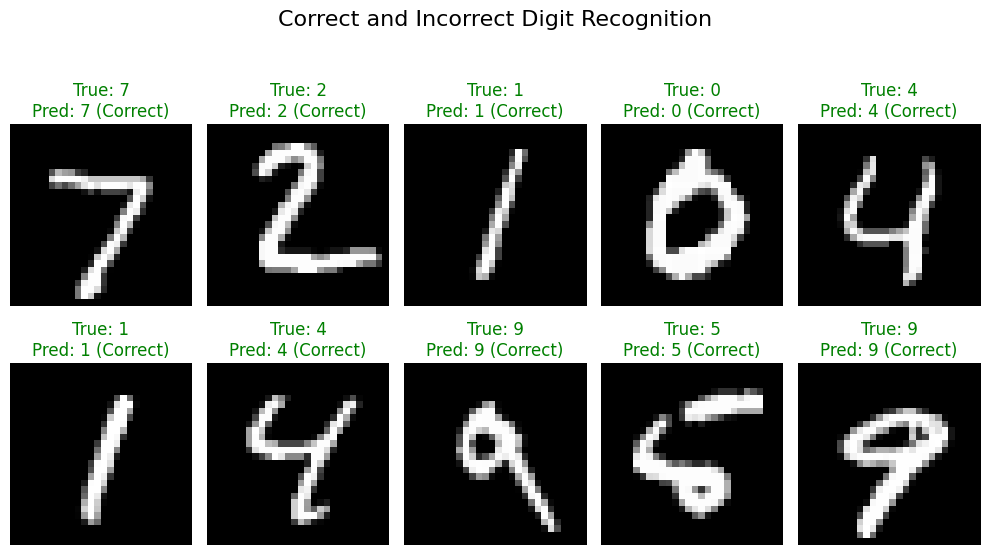

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize correct and incorrect predictions
def visualize_digit_recognition_results(x_test, y_test, digit_model, n=10):
    # Get model predictions
    predictions = digit_model.predict(x_test[:n])

    # Get the predicted labels (max probability index)
    predicted_labels = np.argmax(predictions, axis=1)

    # Get the actual labels
    true_labels = np.argmax(y_test[:n], axis=1)

    # Plot the results
    plt.figure(figsize=(10, 6))
    
    # Loop over the first n images (5 above, 5 below)
    for i in range(n):
        ax = plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')  # Reshape to (28, 28) for visualization
        plt.axis('off')
        
        # Label for original image
        label = f"True: {true_labels[i]}\nPred: {predicted_labels[i]}"
        
        # Check if the prediction is correct or not
        if true_labels[i] == predicted_labels[i]:
            ax.title.set_text(f"{label} (Correct)")
            ax.title.set_color('green')  # Green if correct
        else:
            ax.title.set_text(f"{label} (Incorrect)")
            ax.title.set_color('red')  # Red if incorrect
    
    # Add a title for the plot
    plt.suptitle('Correct and Incorrect Digit Recognition', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust to make room for the suptitle
    plt.show()

# Call the function to display results
visualize_digit_recognition_results(x_test, y_test, cnn_digit_rec_model, n=10)
